In [12]:
import pandas as pd
import numpy as np
import string
import random
import torch
import math
import collections
import dgl
import matplotlib.pyplot as plt
import tqdm
import sklearn.metrics as metrics
import os
os.environ["DATASET_DIR"] = "/Users/rustamwarwick/Documents/Warwick/d3-gnn/datasets"

# Models

In [2]:
class SAGE(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , batchnorm=True):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(dgl.nn.SAGEConv(in_channels, hidden_channels, aggregator_type="mean"))
        self.bns = torch.nn.ModuleList()
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(dgl.nn.SAGEConv(hidden_channels, hidden_channels, aggregator_type="mean"))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(dgl.nn.SAGEConv(hidden_channels, out_channels, aggregator_type="mean"))

        self.dropout = dropout
        self.num_layers = num_layers

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, g, x):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(g[i],x)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = torch.relu(x)
            x = torch.dropout(x, p=self.dropout, train=self.training)
        x = self.convs[-1](g[-1],x)
        return x.log_softmax(dim=-1)

# Datasets

In [7]:
class Dataset:
    def __init__(self, graph, train_mask, test_mask, val_mask, device=torch.device("cpu"), num_snapshots=12):
        self.graph = graph
        self.train_mask = train_mask
        self.test_mask = test_mask
        self.val_mask = val_mask
        self.num_snapshots = num_snapshots
        self.device = device
        
        
    def train(self, model, g=None, train_mask=None,  batch_size=512, shuffle=True, epochs=5):
        g = g if g is not None else self.graph
        train_mask = train_mask if train_mask is not None else self.train_mask
        model.train(True)
        sampler_full = dgl.dataloading.MultiLayerFullNeighborSampler(model.num_layers)
        dataloader = dgl.dataloading.DataLoader(
        g, train_mask, sampler_full,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=False,
        num_workers=4)
        opt = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-5)
        loss = torch.nn.NLLLoss(weight=torch.tensor([1, 1/self.class_imbalance]))
        for epoch in tqdm.tqdm(range(epochs)):
            losses = list()
            for input_nodes, output_nodes, blocks in dataloader:
                input_features = blocks[0].srcdata['x']
                output_labels = blocks[-1].dstdata['y']
                output_predictions = model(blocks, input_features)
                loss_value = loss(output_predictions, output_labels)
                opt.zero_grad()
                loss_value.backward()
                losses.append(loss_value.item())
                opt.step()
            print(np.array(losses).sum() / len(losses))
    
    def test(self, model, g = None, test_mask = None):
        g = g if g is not None else self.graph
        test_mask = test_mask if test_mask is not None else self.test_mask
        model.train(False)
        sampler_full = dgl.dataloading.MultiLayerFullNeighborSampler(model.num_layers)
        test_dataloader = dgl.dataloading.DataLoader(
            g, test_mask, sampler_full,
            batch_size=test_mask.shape[0],
            shuffle=True,
            drop_last=False,
            num_workers=4)
        input_nodes, output_nodes, blocks = next(iter(test_dataloader))
        input_features = blocks[0].srcdata['x']
        output_labels = blocks[-1].dstdata['y']
        return model(blocks, input_features), output_labels
    
    def get_snapshot(self, start:int, end = None):
        assert start < self.num_snapshots, "No more snapshots"
        snapshot_contains = math.ceil(self.graph.num_edges() / self.num_snapshots)
        if end is None:
            # Just retrieve the snapshot starting from previous one
            end = start + 1
        assert start < end, "Start snapshot should be less than end snapshot"
        start_ind = snapshot_contains * start
        end_ind = min(self.graph.num_edges(), snapshot_contains * end)
        g = dgl.graph((self.graph.edges()[0][start_ind:end_ind], self.graph.edges()[1][start_ind:end_ind]), num_nodes=self.graph.num_nodes())
        for key, val in self.graph.ndata.items():
            g.ndata[key] = val
        for key, val in self.graph.edata.items():
            g.edata[key] = val
        return g
        

## GRaphFin

In [8]:
class DGraphFin(Dataset):
    def __init__(self, device = torch.device("cpu"), *args, **kwargs):
        res = np.load(os.path.join(os.environ["DATASET_DIR"], "DGraphFin","dgraphfin.npz"))
        edges = res['edge_index']
        g = dgl.graph((edges[:,0], edges[:,1]), device=device)
        g.ndata["x"] = torch.tensor(res['x']).type(torch.float32).to(device)
        g.ndata["y"] = torch.tensor(res['y']).to(device)
        self.class_imbalance = (g.ndata['y'] == 1).sum() / (g.ndata['y'] == 0).sum()
        super(DGraphFin, self).__init__(g, res['train_mask'], res['test_mask'], res['valid_mask'], device=device, *args, **kwargs)

# Code

In [19]:
def first_snapshot_train(model, dataset, epochs=100):
    rocs = list()
    for i in tqdm.tqdm(range(dataset.num_snapshots)):
        g = dataset.get_snapshot(0, i + 1)
        degrees = g.out_degrees() + g.in_degrees()
        if i==0:
                # Train only on first snapshot
                dataset.train(model, g=g, epochs=epochs, train_mask=dataset.train_mask[degrees[dataset.train_mask] > 1])
        output_predictions, output_labels = dataset.test(model, g, test_mask=dataset.test_mask[degrees[dataset.test_mask] > 1])
        output_predictions = output_predictions.exp()
        rocs.append(metrics.roc_auc_score(output_labels.detach(), output_predictions[:,1].detach()))
    return rocs

def online_learning(model, dataset, epochs=20):
    rocs = list()
    for i in tqdm.tqdm(range(dataset.num_snapshots)):
        g = dataset.get_snapshot(i)
        degrees = g.out_degrees() + g.in_degrees()
        dataset.train(model, g=g, epochs=epochs, train_mask=dataset.train_mask[degrees[dataset.train_mask] > 1])
        g = dataset.get_snapshot(0, i + 1)
        degrees = g.out_degrees() + g.in_degrees()
        output_predictions, output_labels = dataset.test(model, g, test_mask=dataset.test_mask[degrees[dataset.test_mask] > 1])
        output_predictions = output_predictions.exp()
        rocs.append(metrics.roc_auc_score(output_labels.detach(), output_predictions[:,1].detach()))
    return rocs
    

In [10]:
model = SAGE(17, 128, 2, 3, 0.3)
dataset = DGraphFin(num_snapshots = 30)
first_snapshot_rocs = first_snapshot_train(model,dataset)

    

  1%|█▋                                                                                                                                                                     | 1/100 [00:01<02:09,  1.31s/it]

1.2049990991751354



  2%|███▎                                                                                                                                                                   | 2/100 [00:02<02:03,  1.26s/it]

1.0532066590256162



  3%|█████                                                                                                                                                                  | 3/100 [00:03<02:01,  1.25s/it]

0.9694518513149686



  4%|██████▋                                                                                                                                                                | 4/100 [00:05<01:59,  1.25s/it]

0.9329461687140994



  5%|████████▎                                                                                                                                                              | 5/100 [00:06<01:58,  1.25s/it]

0.8099857535627153



  6%|██████████                                                                                                                                                             | 6/100 [00:07<01:56,  1.24s/it]

0.9574680626392365



  7%|███████████▋                                                                                                                                                           | 7/100 [00:08<01:57,  1.26s/it]

0.9285022020339966



  8%|█████████████▎                                                                                                                                                         | 8/100 [00:10<01:55,  1.26s/it]

0.7801017728116777



  9%|███████████████                                                                                                                                                        | 9/100 [00:11<01:53,  1.25s/it]

0.9310058487786187



 10%|████████████████▌                                                                                                                                                     | 10/100 [00:12<01:51,  1.24s/it]

0.8880196611086527



 11%|██████████████████▎                                                                                                                                                   | 11/100 [00:13<01:50,  1.25s/it]

0.8433583246337043



 12%|███████████████████▉                                                                                                                                                  | 12/100 [00:14<01:49,  1.24s/it]

0.7057089077101814



 13%|█████████████████████▌                                                                                                                                                | 13/100 [00:16<01:50,  1.27s/it]

0.8002317746480306



 14%|███████████████████████▏                                                                                                                                              | 14/100 [00:17<01:47,  1.25s/it]

0.8063145577907562



 15%|████████████████████████▉                                                                                                                                             | 15/100 [00:18<01:45,  1.25s/it]

0.7261426697174708



 16%|██████████████████████████▌                                                                                                                                           | 16/100 [00:20<01:45,  1.25s/it]

0.7131847805447049



 17%|████████████████████████████▏                                                                                                                                         | 17/100 [00:21<01:43,  1.25s/it]

0.7471127526627647



 18%|█████████████████████████████▉                                                                                                                                        | 18/100 [00:22<01:42,  1.25s/it]

0.7423589494493272



 19%|███████████████████████████████▌                                                                                                                                      | 19/100 [00:23<01:40,  1.24s/it]

0.6625285181734297



 20%|█████████████████████████████████▏                                                                                                                                    | 20/100 [00:24<01:39,  1.24s/it]

0.9265401015679041



 21%|██████████████████████████████████▊                                                                                                                                   | 21/100 [00:26<01:37,  1.23s/it]

0.8882849282688565



 22%|████████████████████████████████████▌                                                                                                                                 | 22/100 [00:27<01:36,  1.24s/it]

0.7107466210921606



 23%|██████████████████████████████████████▏                                                                                                                               | 23/100 [00:28<01:34,  1.23s/it]

0.7349240796433555



 24%|███████████████████████████████████████▊                                                                                                                              | 24/100 [00:29<01:33,  1.23s/it]

0.7578717519839605



 25%|█████████████████████████████████████████▌                                                                                                                            | 25/100 [00:31<01:32,  1.23s/it]

0.7186701628896925



 26%|███████████████████████████████████████████▏                                                                                                                          | 26/100 [00:32<01:30,  1.23s/it]

0.6468536290857527



 27%|████████████████████████████████████████████▊                                                                                                                         | 27/100 [00:33<01:29,  1.22s/it]

0.7440929164489111



 28%|██████████████████████████████████████████████▍                                                                                                                       | 28/100 [00:34<01:27,  1.22s/it]

0.6559629291296005



 29%|████████████████████████████████████████████████▏                                                                                                                     | 29/100 [00:35<01:26,  1.21s/it]

0.7026476864185598



 30%|█████████████████████████████████████████████████▊                                                                                                                    | 30/100 [00:37<01:24,  1.21s/it]

0.7209597329298655



 31%|███████████████████████████████████████████████████▍                                                                                                                  | 31/100 [00:38<01:24,  1.23s/it]

0.6990088340308931



 32%|█████████████████████████████████████████████████████                                                                                                                 | 32/100 [00:39<01:23,  1.23s/it]

0.6940750297572877



 33%|██████████████████████████████████████████████████████▊                                                                                                               | 33/100 [00:40<01:22,  1.23s/it]

0.7090666343768438



 34%|████████████████████████████████████████████████████████▍                                                                                                             | 34/100 [00:42<01:21,  1.23s/it]

0.6218063417408202



 35%|██████████████████████████████████████████████████████████                                                                                                            | 35/100 [00:43<01:20,  1.23s/it]

0.6092932588524289



 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 36/100 [00:44<01:18,  1.23s/it]

0.7180080827739503



 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 37/100 [00:45<01:17,  1.23s/it]

0.5717291227645345



 38%|███████████████████████████████████████████████████████████████                                                                                                       | 38/100 [00:47<01:15,  1.22s/it]

0.6487672279278437



 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 39/100 [00:48<01:14,  1.23s/it]

0.6004704766803317



 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 40/100 [00:49<01:13,  1.22s/it]

0.6594302356243134



 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 41/100 [00:50<01:12,  1.22s/it]

0.6610475662681792



 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 42/100 [00:51<01:10,  1.22s/it]

0.6836381339364581



 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 43/100 [00:53<01:09,  1.22s/it]

0.6318928980165057



 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 44/100 [00:54<01:08,  1.23s/it]

0.6467442545625899



 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 45/100 [00:55<01:07,  1.22s/it]

0.6670952207512326



 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 46/100 [00:56<01:05,  1.21s/it]

0.6161231332355075



 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 47/100 [00:58<01:04,  1.22s/it]

0.6774002346727583



 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 48/100 [00:59<01:03,  1.22s/it]

0.6290488888820013



 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 49/100 [01:00<01:02,  1.23s/it]

0.6612649245394601



 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 50/100 [01:01<01:01,  1.24s/it]

0.5906338840723038



 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 51/100 [01:02<01:00,  1.23s/it]

0.5686714202165604



 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 52/100 [01:04<00:58,  1.23s/it]

0.6668709417184194



 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 53/100 [01:05<00:57,  1.22s/it]

0.6153598361545138



 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 54/100 [01:06<00:56,  1.22s/it]

0.6129890332619349



 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 55/100 [01:07<00:54,  1.22s/it]

0.5530955129199557



 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 56/100 [01:09<00:53,  1.23s/it]

0.5469021184576882



 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 57/100 [01:10<00:52,  1.22s/it]

0.592561822798517



 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 58/100 [01:11<00:51,  1.22s/it]

0.6270102196269565



 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 59/100 [01:12<00:49,  1.22s/it]

0.6517652852667702



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 60/100 [01:13<00:48,  1.22s/it]

0.6022164970636368



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 61/100 [01:15<00:48,  1.24s/it]

0.6170888228548898



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 62/100 [01:16<00:47,  1.24s/it]

0.5960652761989169



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 63/100 [01:17<00:46,  1.26s/it]

0.5575375424491035



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 64/100 [01:18<00:45,  1.26s/it]

0.555013539062606



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 65/100 [01:20<00:44,  1.26s/it]

0.5301579005188413



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 66/100 [01:21<00:42,  1.25s/it]

0.6037687675820457



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 67/100 [01:22<00:41,  1.25s/it]

0.5711022433307436



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 68/100 [01:23<00:39,  1.25s/it]

0.5595742480622398



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 69/100 [01:25<00:39,  1.27s/it]

0.6140297634734048



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 70/100 [01:26<00:37,  1.25s/it]

0.540987158815066



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 71/100 [01:27<00:36,  1.24s/it]

0.6269407288895713



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 72/100 [01:28<00:34,  1.24s/it]

0.5948778606123395



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 73/100 [01:30<00:33,  1.23s/it]

0.6800973183578916



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 74/100 [01:31<00:31,  1.23s/it]

0.5770192245642344



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 75/100 [01:32<00:30,  1.22s/it]

0.5828723791572783



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 76/100 [01:33<00:29,  1.22s/it]

0.5947552190886604



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 77/100 [01:35<00:28,  1.23s/it]

0.5187973744339414



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 78/100 [01:36<00:27,  1.23s/it]

0.6164848986599181



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 79/100 [01:37<00:25,  1.22s/it]

0.5812771792213122



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 80/100 [01:38<00:24,  1.24s/it]

0.5174148695336448



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 81/100 [01:40<00:23,  1.24s/it]

0.5677075684070587



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 82/100 [01:41<00:22,  1.24s/it]

0.5102697925435172



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 83/100 [01:42<00:20,  1.23s/it]

0.5432767454120848



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 84/100 [01:43<00:19,  1.22s/it]

0.5619158786204126



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 85/100 [01:44<00:18,  1.24s/it]

0.5453997552394867



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 86/100 [01:46<00:17,  1.26s/it]

0.5252301411496269



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 87/100 [01:47<00:16,  1.24s/it]

0.5399361418353187



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 88/100 [01:48<00:14,  1.24s/it]

0.5014614644977782



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 89/100 [01:49<00:13,  1.23s/it]

0.57164166867733



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 90/100 [01:51<00:12,  1.23s/it]

0.5163536700937483



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 91/100 [01:52<00:11,  1.24s/it]

0.5406374682982763



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 92/100 [01:53<00:09,  1.25s/it]

0.5035129686196645



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 93/100 [01:54<00:08,  1.25s/it]

0.5143894503513972



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 94/100 [01:56<00:07,  1.25s/it]

0.5648422224654092



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 95/100 [01:57<00:06,  1.24s/it]

0.5032620877027512



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96/100 [01:58<00:04,  1.23s/it]

0.5284283243947558



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 97/100 [01:59<00:03,  1.23s/it]

0.5774686882893244



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98/100 [02:01<00:02,  1.23s/it]

0.5443106624815199



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [02:02<00:01,  1.24s/it]

0.5738893730772866



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]

0.544168598122067



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:49<00:00,  5.64s/it]


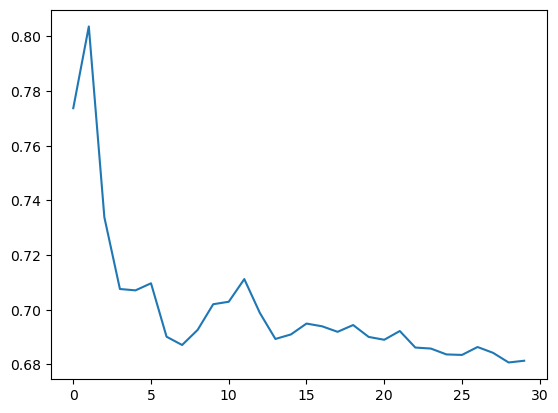

In [18]:
plt.plot(list(range(len(first_snapshot_rocs))), first_snapshot_rocs)

In [20]:
model = SAGE(17, 128, 2, 3, 0.3)
dataset = DGraphFin(num_snapshots = 30)
first_snapshot_rocs = online_learning(model,dataset)

    

  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:31,  1.68s/it]

1.1148942212263744



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:25,  1.43s/it]

1.0044130782286327



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:04<00:22,  1.35s/it]

0.9831869337293837



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:05<00:21,  1.31s/it]

0.8310739431116316



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:06<00:19,  1.33s/it]

0.8162898139821159



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:08<00:18,  1.31s/it]

0.8592272135946486



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:09<00:16,  1.30s/it]

0.8080887082550261



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:10<00:15,  1.31s/it]

0.8290007809797922



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:11<00:14,  1.30s/it]

0.8174100948704613



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:13<00:12,  1.29s/it]

0.8038842628399531



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:14<00:11,  1.28s/it]

0.7138162172502942



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:15<00:10,  1.29s/it]

0.7253469228744507



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:17<00:09,  1.29s/it]

0.75410339070691



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:18<00:07,  1.31s/it]

0.7930018256107966



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:19<00:06,  1.32s/it]

0.7287579385770692



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:21<00:05,  1.34s/it]

0.8382966832982169



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:22<00:04,  1.36s/it]

0.738746266398165



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:23<00:02,  1.33s/it]

0.7063606315188937



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:25<00:01,  1.45s/it]

0.679290748304791



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

0.6852801475259993



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.15s/it]

0.7844275898403592



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.12s/it]

1.175366719563802



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:18,  1.11s/it]

0.7876414855321249



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.14s/it]

0.6817430257797241



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.17s/it]

0.8338976303736368



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:16,  1.16s/it]

0.6925508677959442



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:15,  1.16s/it]

0.7463716997040643



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:14,  1.20s/it]

0.677978452708986



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:14,  1.30s/it]

0.7771634327040778



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:12<00:13,  1.33s/it]

0.7443368799156613



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:13<00:11,  1.25s/it]

0.8164462447166443



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:14<00:09,  1.19s/it]

0.6939214004410638



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:15<00:08,  1.15s/it]

0.6818947262234158



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:06,  1.14s/it]

0.6604447265466055



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.16s/it]

0.6970602770646414



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:19<00:04,  1.23s/it]

0.6383984287579855



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:20<00:03,  1.30s/it]

0.715576665269004



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:21<00:02,  1.23s/it]

0.6710782812701331



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:22<00:01,  1.19s/it]

0.709091004398134



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]

0.6997941368156009



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:24,  1.26s/it]

0.811772283166647



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:21,  1.18s/it]

0.6554318442940712



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.15s/it]

0.7914956584572792



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.15s/it]

0.719154592603445



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.15s/it]

0.6600942388176918



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:16,  1.17s/it]

0.6447034552693367



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:15,  1.18s/it]

0.6610109433531761



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.16s/it]

0.6887263581156731



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.16s/it]

0.7374823614954948



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.15s/it]

0.6666874475777149



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.14s/it]

0.7344862818717957



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.14s/it]

0.5963961556553841



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.13s/it]

0.6045469678938389



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:06,  1.15s/it]

0.6822469010949135



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.14s/it]

0.5963477306067944



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.16s/it]

0.5571081265807152



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.17s/it]

0.624000396579504



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.15s/it]

0.5745786353945732



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.14s/it]

0.5483916327357292



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.15s/it]

0.5437039844691753



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:25,  1.34s/it]

0.5670942291617393



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:21,  1.18s/it]

0.7116628214716911



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.15s/it]

0.5775191150605679



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.14s/it]

0.5411670580506325



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.13s/it]

0.6323484294116497



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.12s/it]

0.5946198031306267



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.12s/it]

0.5350006446242332



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.12s/it]

0.5322299525141716



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.12s/it]

0.4868557080626488



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.11s/it]

0.5436723083257675



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.11s/it]

0.5276194661855698



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.11s/it]

0.4885120205581188



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.11s/it]

0.5320873931050301



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.11s/it]

0.47771625220775604



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.11s/it]

0.5581765323877335



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:17<00:04,  1.11s/it]

0.4880106523633003



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.11s/it]

0.5290831960737705



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.12s/it]

0.5111681334674358



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.10s/it]

0.46021541953086853



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]

0.4317280650138855



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.12s/it]

0.8655574172735214



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.12s/it]

0.8285101614892483



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.12s/it]

0.6530298553407192



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.12s/it]

0.7161773182451725



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.13s/it]

0.6635931544005871



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.13s/it]

0.7231701575219631



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.6026466712355614



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.14s/it]

0.6577558889985085



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.6025064699351788



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.10s/it]

0.5298819728195667



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.11s/it]

0.7786006554961205



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.11s/it]

0.5313812270760536



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.11s/it]

0.5489709973335266



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.12s/it]

0.5956987179815769



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.12s/it]

0.5390746183693409



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:17<00:04,  1.12s/it]

0.5522317476570606



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.12s/it]

0.742693230509758



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.11s/it]

0.5837335772812366



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.11s/it]

0.640300840139389



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]

0.7164067216217518



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.12s/it]

0.5959560982882977



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:19,  1.10s/it]

0.7979716062545776



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:18,  1.12s/it]

0.6574186757206917



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.12s/it]

0.7957225330173969



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.13s/it]

0.9102663062512875



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.13s/it]

0.6536202728748322



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.5304298885166645



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.13s/it]

0.7074315771460533



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.5723320320248604



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.14s/it]

0.664777796715498



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.14s/it]

0.8107450343668461



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.14s/it]

0.64420510455966



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.13s/it]

0.5799805708229542



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.13s/it]

0.6120247505605221



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.16s/it]

0.6634120792150497



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.15s/it]

0.5792248547077179



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.14s/it]

0.6002805195748806



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.14s/it]

0.6446813866496086



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.13s/it]

0.6405303403735161



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]

0.5627740733325481



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:20,  1.08s/it]

0.647138025611639



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:19,  1.10s/it]

0.5881719216704369



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:18,  1.11s/it]

0.5550527051091194



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.11s/it]

0.6745649836957455



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.12s/it]

0.5862691104412079



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.11s/it]

0.5978987812995911



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.12s/it]

0.5353423021733761



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:08<00:13,  1.12s/it]

0.5856990478932858



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.12s/it]

0.553283654153347



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.12s/it]

0.5347998961806297



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.13s/it]

0.5809562914073467



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.12s/it]

0.4952421672642231



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.12s/it]

0.5544596128165722



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.12s/it]

0.46427496150135994



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.12s/it]

0.5399569310247898



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:17<00:04,  1.12s/it]

0.539012972265482



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:18<00:03,  1.12s/it]

0.5292344391345978



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.12s/it]

0.5137403234839439



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.12s/it]

0.5711763612926006



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]

0.540613453835249



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.11s/it]

0.6247156597673893



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.11s/it]

0.6009643338620663



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.13s/it]

0.6967861875891685



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.13s/it]

0.6176213920116425



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.16s/it]

0.4985508434474468



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:16,  1.15s/it]

0.5949025899171829



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.14s/it]

0.5909606926143169



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.13s/it]

0.5925520434975624



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.5407443828880787



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.13s/it]

0.5354464761912823



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.12s/it]

0.546953696757555



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.12s/it]

0.6068242751061916



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.12s/it]

0.5435631908476353



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.12s/it]

0.5687753334641457



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.10s/it]

0.5345591381192207



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:17<00:04,  1.08s/it]

0.511386550962925



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:18<00:03,  1.09s/it]

0.5410366952419281



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.10s/it]

0.5534252412617207



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.11s/it]

0.5462661981582642



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]

0.544042807072401



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.12s/it]

0.5865950211882591



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.12s/it]

0.5776709727942944



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:18,  1.11s/it]

0.5883243568241596



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.11s/it]

0.5648838616907597



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.11s/it]

0.6456559933722019



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.11s/it]

0.5307550802826881



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.11s/it]

0.6141000501811504



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:08<00:13,  1.12s/it]

0.578767903149128



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.5963271632790565



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.13s/it]

0.5788528583943844



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.12s/it]

0.5721072591841221



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.12s/it]

0.49238670617341995



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.12s/it]

0.567626740783453



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.12s/it]

0.5617429539561272



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.12s/it]

0.5041713081300259



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:17<00:04,  1.12s/it]

0.4522904306650162



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.13s/it]

0.5087920986115932



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.13s/it]

0.4640606939792633



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.13s/it]

0.5404570661485195



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]

0.5061028264462948



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.14s/it]

0.5866659842431545



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.12s/it]

0.6216876059770584



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:18,  1.12s/it]

0.5861087404191494



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.12s/it]

0.6374456435441971



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.12s/it]

0.5779604353010654



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.12s/it]

0.5678649432957172



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.5391070283949375



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.13s/it]

0.5499740578234196



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.6268322840332985



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.13s/it]

0.5435799099504948



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.13s/it]

0.5235808901488781



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.12s/it]

0.6618716306984425



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.13s/it]

0.5374104902148247



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.13s/it]

0.5229553058743477



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.12s/it]

0.5814110487699509



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.13s/it]

0.4957451559603214



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.13s/it]

0.5355933494865894



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.13s/it]

0.5704033486545086



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.13s/it]

0.5102531388401985



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]

0.5290119834244251



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:20,  1.10s/it]

0.5233012437820435



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.12s/it]

0.5561479739844799



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.12s/it]

0.4857957400381565



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.12s/it]

0.6295142285525799



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.12s/it]

0.539339255541563



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.09s/it]

0.5309915877878666



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.09s/it]

0.5301518104970455



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:08<00:13,  1.10s/it]

0.5501815490424633



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:09<00:12,  1.11s/it]

0.5190476626157761



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.11s/it]

0.5261586382985115



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.12s/it]

0.47229764983057976



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.12s/it]

0.48351408168673515



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.11s/it]

0.5926379188895226



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.09s/it]

0.484554048627615



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.09s/it]

0.5523532256484032



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:17<00:04,  1.10s/it]

0.47205613926053047



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:18<00:03,  1.11s/it]

0.4562084302306175



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:19<00:02,  1.12s/it]

0.4925372824072838



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.12s/it]

0.4111177660524845



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.11s/it]

0.47373421862721443



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.12s/it]

0.911752738058567



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.11s/it]

0.7634679339826107



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:18,  1.12s/it]

0.7920940481126308



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.11s/it]

0.768879272043705



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.12s/it]

0.848701361566782



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.12s/it]

0.6283355616033077



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.6681113168597221



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:08<00:13,  1.12s/it]

0.8276105523109436



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.11s/it]

0.7888184785842896



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.11s/it]

0.6137508638203144



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.11s/it]

0.610188040882349



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.11s/it]

0.6800165139138699



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.12s/it]

0.6069151572883129



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.12s/it]

0.5982068590819836



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.13s/it]

0.6494067758321762



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:17<00:04,  1.13s/it]

0.6112008169293404



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.13s/it]

0.666356772184372



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.12s/it]

0.5534318052232265



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.13s/it]

0.6620628535747528



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]

0.7844527326524258



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:24,  1.28s/it]

0.7442534565925598



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:23,  1.29s/it]

0.843373529613018



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:21,  1.25s/it]

0.7268193066120148



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:19,  1.21s/it]

0.7456046007573605



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:06<00:17,  1.20s/it]

0.6372271478176117



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:07<00:16,  1.18s/it]

0.6443022266030312



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:15,  1.17s/it]

0.7223961055278778



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.15s/it]

0.843972884118557



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.14s/it]

0.7008710615336895



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.15s/it]

0.6043784320354462



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.16s/it]

0.6023926846683025



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:14<00:09,  1.18s/it]

0.6959532350301743



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:15<00:08,  1.18s/it]

0.6007435619831085



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:07,  1.17s/it]

0.6830589026212692



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.16s/it]

0.6331415772438049



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.16s/it]

0.6553687080740929



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.15s/it]

0.5815868861973286



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:21<00:02,  1.15s/it]

0.5973826572299004



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:22<00:01,  1.15s/it]

0.5882609114050865



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]

0.5155956968665123



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.12s/it]

0.51192631945014



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.15s/it]

0.5735367424786091



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.16s/it]

0.5359237939119339



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.17s/it]

0.6255019791424274



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:18,  1.22s/it]

0.6429146230220795



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:07<00:17,  1.24s/it]

0.5227667652070522



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:15,  1.21s/it]

0.5589343681931496



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:14,  1.19s/it]

0.6113206222653389



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:13,  1.20s/it]

0.5622348636388779



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.20s/it]

0.5641844607889652



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:13<00:10,  1.20s/it]

0.47931213676929474



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:14<00:09,  1.19s/it]

0.5399873144924641



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:15<00:08,  1.23s/it]

0.5558276325464249



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:17<00:07,  1.27s/it]

0.5372613705694675



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:18<00:06,  1.29s/it]

0.4803685285151005



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:19<00:04,  1.25s/it]

0.6114782840013504



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:20<00:03,  1.21s/it]

0.4792183041572571



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:21<00:02,  1.20s/it]

0.46738775447010994



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:22<00:01,  1.19s/it]

0.5349180661141872



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]

0.5208596959710121



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:22,  1.20s/it]

0.6041776649653912



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:21,  1.18s/it]

0.7016663774847984



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.16s/it]

0.6262348890304565



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.15s/it]

0.5830078832805157



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.14s/it]

0.5388417057693005



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:16,  1.15s/it]

0.4850473403930664



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:14,  1.14s/it]

0.6797257848083973



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.13s/it]

0.601557057350874



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.14s/it]

0.5448072329163551



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.14s/it]

0.5307591147720814



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.14s/it]

0.5210946090519428



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.13s/it]

0.47516193985939026



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.13s/it]

0.49570825695991516



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.14s/it]

0.4611232094466686



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.13s/it]

0.5411194153130054



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.14s/it]

0.4876747690141201



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.14s/it]

0.48140064999461174



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.13s/it]

0.49563775211572647



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.13s/it]

0.41562107391655445



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]

0.41906238347291946



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:20,  1.09s/it]

0.7165715917944908



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:19,  1.11s/it]

0.6299945190548897



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.12s/it]

0.6191476248204708



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.12s/it]

0.6138265915215015



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.11s/it]

0.5412288717925549



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.13s/it]

0.48637229949235916



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.5710148252546787



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.14s/it]

0.5673749893903732



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.14s/it]

0.5434776619076729



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.14s/it]

0.6007469035685062



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.13s/it]

0.5367487110197544



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.13s/it]

0.5465721376240253



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.13s/it]

0.5358052775263786



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.13s/it]

0.5766509287059307



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.14s/it]

0.5047626979649067



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.13s/it]

0.5226030834019184



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.13s/it]

0.4906598664820194



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.14s/it]

0.5179388448596001



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.13s/it]

0.51988185942173



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]

0.49817638471722603



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:22,  1.17s/it]

0.5646904818713665



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.15s/it]

0.6003930792212486



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:20,  1.20s/it]

0.585025105625391



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.17s/it]

0.5823252536356449



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.16s/it]

0.5906054973602295



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:16,  1.15s/it]

0.5918553024530411



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:14,  1.14s/it]

0.6189066804945469



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.14s/it]

0.6096734032034874



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.5599570833146572



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.14s/it]

0.6472918204963207



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.14s/it]

0.5724399611353874



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.14s/it]

0.5717886611819267



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.14s/it]

0.566452369093895



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:06,  1.14s/it]

0.569876529276371



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.14s/it]

0.4971887916326523



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.14s/it]

0.5283379927277565



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.14s/it]

0.5648527294397354



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.13s/it]

0.5921739786863327



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.13s/it]

0.5309385806322098



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]

0.5651867911219597



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:20,  1.08s/it]

0.46867892891168594



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.11s/it]

0.5284069068729877



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.12s/it]

0.5313199311494827



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.12s/it]

0.5149192176759243



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.13s/it]

0.5117728598415852



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.13s/it]

0.522386871278286



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.46150559559464455



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:14,  1.17s/it]

0.5525805056095123



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.16s/it]

0.5567015334963799



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.16s/it]

0.483997143805027



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.14s/it]

0.47131195291876793



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.14s/it]

0.4555019177496433



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.14s/it]

0.45600955188274384



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.14s/it]

0.4556635729968548



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.14s/it]

0.43002358078956604



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.13s/it]

0.45712050050497055



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.14s/it]

0.4812659062445164



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.14s/it]

0.5125788152217865



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.14s/it]

0.4010210856795311



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]

0.4491499364376068



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:20,  1.08s/it]

0.5809349678456783



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.12s/it]

0.48621729016304016



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.13s/it]

0.44923556596040726



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.15s/it]

0.5048898681998253



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.15s/it]

0.443046011030674



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.12s/it]

0.4826677031815052



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.43943236768245697



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.13s/it]

0.4677039831876755



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.4540702551603317



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.14s/it]

0.4271441847085953



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.14s/it]

0.4911579117178917



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.15s/it]

0.46663379669189453



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:08,  1.15s/it]

0.4227459281682968



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.15s/it]

0.42949507012963295



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.14s/it]

0.40336644276976585



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.14s/it]

0.3790335562080145



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.15s/it]

0.38366053998470306



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.14s/it]

0.4290369190275669



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.14s/it]

0.39654139056801796



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]

0.3678052294999361



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.15s/it]

0.8727877661585808



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.13s/it]

0.7812839895486832



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.13s/it]

0.8559728115797043



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.13s/it]

1.075604435056448



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.14s/it]

0.9035732410848141



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.14s/it]

0.894217923283577



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.15s/it]

0.8471174389123917



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:14,  1.18s/it]

0.8536678999662399



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.15s/it]

0.6932923495769501



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.15s/it]

0.765246145427227



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.15s/it]

0.648185208439827



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.14s/it]

0.6168629676103592



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.14s/it]

0.7254657112061977



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.13s/it]

0.6791191883385181



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.13s/it]

0.6727383509278297



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.13s/it]

0.6629574075341225



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.15s/it]

0.6059449128806591



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.15s/it]

0.7419853135943413



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.14s/it]

0.6356028132140636



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]

0.694786611944437



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.14s/it]

0.6940588317811489



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:21,  1.18s/it]

0.6712791882455349



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.15s/it]

0.5654098130762577



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.17s/it]

0.5860120169818401



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.12s/it]

0.5458167381584644



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:16,  1.15s/it]

0.5296368487179279



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:14,  1.15s/it]

0.5932428613305092



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.14s/it]

0.6572385877370834



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.14s/it]

0.49730413034558296



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.14s/it]

0.6181708723306656



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.14s/it]

0.495282381772995



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.15s/it]

0.48805470019578934



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:08,  1.16s/it]

0.497652605175972



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:06,  1.16s/it]

0.5439967140555382



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.16s/it]

0.517390638589859



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.15s/it]

0.47609684616327286



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.16s/it]

0.4982505477964878



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.15s/it]

0.4728373847901821



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.14s/it]

0.4670286551117897



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]

0.4745364263653755



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:20,  1.06s/it]

0.781667947769165



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:19,  1.10s/it]

0.8749502040445805



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.12s/it]

0.608005452901125



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.12s/it]

0.6211655363440514



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.12s/it]

0.711930438876152



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.13s/it]

0.7422884367406368



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.6018280759453773



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:08<00:13,  1.13s/it]

0.5989329740405083



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.8106972798705101



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.14s/it]

0.6448634937405586



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.13s/it]

0.5735791511833668



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.14s/it]

0.5478565730154514



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.14s/it]

0.6913575157523155



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.13s/it]

0.5921853072941303



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.13s/it]

0.5281475633382797



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.14s/it]

0.5523022450506687



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.14s/it]

0.56365517526865



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.15s/it]

0.5956818833947182



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.15s/it]

0.4854808785021305



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]

0.5810875706374645



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.14s/it]

0.523538127541542



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:19,  1.09s/it]

0.5145925022661686



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:18,  1.11s/it]

0.494757816195488



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.11s/it]

0.4941731132566929



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.13s/it]

0.4953659102320671



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.13s/it]

0.4521189294755459



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.4649595320224762



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.13s/it]

0.4013296104967594



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.4619043916463852



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.13s/it]

0.4204496704041958



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.14s/it]

0.41642603650689125



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.14s/it]

0.46327268704771996



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.14s/it]

0.41041184961795807



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.15s/it]

0.41609977185726166



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.15s/it]

0.4262613281607628



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.14s/it]

0.4427480138838291



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.14s/it]

0.40690312534570694



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.14s/it]

0.40428401343524456



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.14s/it]

0.47306328639388084



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]

0.45287029072642326



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:20,  1.10s/it]

0.5061687361449003



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.13s/it]

0.5363083556294441



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.13s/it]

0.491621857509017



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.13s/it]

0.49591251462697983



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.14s/it]

0.4189382903277874



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.13s/it]

0.45078473538160324



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.13s/it]

0.46902306750416756



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.13s/it]

0.4516595173627138



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.4393031559884548



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.13s/it]

0.4322869535535574



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.11s/it]

0.542020920664072



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.11s/it]

0.43567134626209736



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.12s/it]

0.4121452532708645



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.12s/it]

0.3756473623216152



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.14s/it]

0.46360379457473755



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.14s/it]

0.45585379749536514



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.12s/it]

0.4703905377537012



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.13s/it]

0.4050236437469721



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.15s/it]

0.4665359705686569



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]

0.47193265706300735



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:21,  1.11s/it]

0.8773532249033451



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.12s/it]

0.7618020176887512



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.13s/it]

0.7274482361972332



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.13s/it]

0.6722870953381062



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.13s/it]

0.6692132838070393



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.14s/it]

0.6119166128337383



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.14s/it]

0.7446481473743916



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.13s/it]

0.754595797508955



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.13s/it]

0.6236351653933525



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.13s/it]

0.6241441927850246



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.13s/it]

0.7665181383490562



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.14s/it]

0.6946898475289345



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.14s/it]

0.6331919468939304



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.14s/it]

0.7041134797036648



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.15s/it]

0.556944478303194



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.15s/it]

0.5348110869526863



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.14s/it]

0.597616646438837



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.14s/it]

0.5100514553487301



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:21<00:01,  1.14s/it]

0.5884541608393192



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]

0.6254767626523972



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:20,  1.10s/it]

0.5305871797932519



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:19,  1.09s/it]

0.4980851941638523



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:18,  1.09s/it]

0.5050547619660696



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:17,  1.08s/it]

0.4520477188958062



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:16,  1.08s/it]

0.47517380118370056



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:15,  1.08s/it]

0.47699154747856987



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:07<00:14,  1.08s/it]

0.5342364178763496



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:08<00:12,  1.07s/it]

0.46313263641463387



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:09<00:11,  1.08s/it]

0.464640027946896



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:10<00:10,  1.08s/it]

0.4545637302928501



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:11<00:09,  1.09s/it]

0.46505413121647304



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:08,  1.09s/it]

0.5774946179654863



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:14<00:07,  1.09s/it]

0.4730294545491536



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:15<00:06,  1.09s/it]

0.4596012168460422



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:16<00:05,  1.10s/it]

0.4098103410667843



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:17<00:04,  1.11s/it]

0.4043430619769626



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:18<00:03,  1.12s/it]

0.4286524819003211



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:19<00:02,  1.13s/it]

0.41721252931488884



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:20<00:01,  1.12s/it]

0.4026445613967048



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.10s/it]

0.4957440098126729



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:22,  1.18s/it]

0.7298678532242775



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:21,  1.20s/it]

0.639683132370313



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:20,  1.20s/it]

0.6350568657120069



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:19,  1.21s/it]

0.6736923431356748



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:06<00:18,  1.21s/it]

0.5916976208488146



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:07<00:16,  1.21s/it]

0.5891583288709322



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:15,  1.19s/it]

0.6292074397206306



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:14,  1.17s/it]

0.6181110292673111



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.16s/it]

0.5696041410168012



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.15s/it]

0.6080757180849711



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.15s/it]

0.5875938013195992



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:14<00:09,  1.16s/it]

0.5509542102615038



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:15<00:08,  1.16s/it]

0.6237670555710793



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:06,  1.14s/it]

0.5628322089711825



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.17s/it]

0.5673045466343561



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.15s/it]

0.5683068707585335



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.14s/it]

0.5518800218900045



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.14s/it]

0.5414784948031107



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:22<00:01,  1.13s/it]

0.5774613469839096



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]

0.5356485868493716



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:22,  1.17s/it]

0.7253482983662531



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:20,  1.16s/it]

0.7282413450571207



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:19,  1.16s/it]

0.6105510088113638



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.16s/it]

0.6508911572969877



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.16s/it]

0.7127475715600528



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:06<00:16,  1.17s/it]

0.5529681191994593



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:15,  1.17s/it]

0.6042996255251077



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:13,  1.16s/it]

0.7118604435370519



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.16s/it]

0.661781886449227



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.16s/it]

0.6169654245559986



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.15s/it]

0.5636565960370578



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.15s/it]

0.6099613629854642



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:15<00:08,  1.15s/it]

0.5442323615917792



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:06,  1.15s/it]

0.5335932030127599



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.15s/it]

0.5206248874847705



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.15s/it]

0.5492803156375885



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.15s/it]

0.5374310796077435



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:20<00:02,  1.15s/it]

0.5960419888679798



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:22<00:01,  1.16s/it]

0.5960828776542957



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]

0.5315025059076456



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:22,  1.21s/it]

0.7524418468986239



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:21,  1.18s/it]

0.7642348089388439



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:20,  1.18s/it]

0.715616722192083



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:18,  1.17s/it]

0.6573194499526706



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.17s/it]

0.6919383768524442



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:07<00:16,  1.17s/it]

0.7107612064906529



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:15,  1.17s/it]

0.677621128303664



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:14,  1.18s/it]

0.6388618839638573



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:12,  1.18s/it]

0.6390060867582049



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:11,  1.18s/it]

0.6326239513499397



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:12<00:10,  1.18s/it]

0.6609265016657966



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:14<00:09,  1.17s/it]

0.6303881577083043



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:15<00:08,  1.17s/it]

0.7081171210323062



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:07,  1.18s/it]

0.7359019432749067



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.17s/it]

0.6431345513888768



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:18<00:04,  1.17s/it]

0.6103469921009881



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:19<00:03,  1.17s/it]

0.6542093604803085



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:21<00:02,  1.17s/it]

0.6404992852892194



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:22<00:01,  1.17s/it]

0.6205522056136813



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]

0.6118501318352563



  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:23,  1.22s/it]

0.6561013420422872



 10%|████████████████▊                                                                                                                                                       | 2/20 [00:02<00:21,  1.20s/it]

0.5697052280108134



 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:03<00:20,  1.19s/it]

0.6296446998914083



 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:04<00:19,  1.19s/it]

0.578835650285085



 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:05<00:17,  1.20s/it]

0.6200716257095337



 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:07<00:16,  1.19s/it]

0.6082931836446126



 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:08<00:15,  1.19s/it]

0.5547036727269491



 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:09<00:14,  1.18s/it]

0.6170646190643311



 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:10<00:13,  1.21s/it]

0.5826503117879231



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:11<00:12,  1.20s/it]

0.5834434608618418



 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:13<00:10,  1.19s/it]

0.545709627866745



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:14<00:09,  1.19s/it]

0.5941238443056742



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:15<00:08,  1.19s/it]

0.6014259199301402



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:16<00:07,  1.19s/it]

0.5612828850746154



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:17<00:05,  1.19s/it]

0.5530205090840657



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:19<00:04,  1.19s/it]

0.6310052812099457



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:20<00:03,  1.18s/it]

0.5450937648614248



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:21<00:02,  1.20s/it]

0.5701103031635284



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:22<00:01,  1.19s/it]

0.5851702491442362



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]

0.582379678885142



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [12:17<00:00, 24.57s/it]


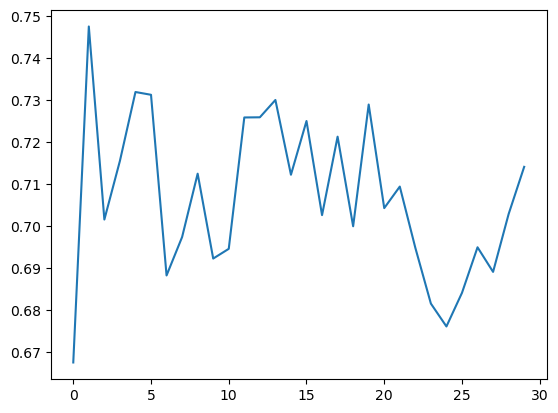

In [21]:
plt.plot(list(range(len(first_snapshot_rocs))), first_snapshot_rocs)

In [120]:
dataset.graph.num_nodes()

3700550